In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification


import torch

from tqdm import tqdm

quick = True

BATCH_SIZE = 32

In [18]:
arabic_dialect_dataset = pd.read_csv('./arabic_dialect.csv')
arabic_dialect_dataset = arabic_dialect_dataset.sample(frac=1).reset_index(drop=True)
arabic_dialect_dataset

,id,user,sentence,region,dialect,dialect_AE,dialect_BH,dialect_DZ,dialect_EG,dialect_IQ,...,dialect_QA,dialect_SA,dialect_SD,dialect_SY,dialect_TN,dialect_YE,region_GULF,region_LEVANT,region_MAGHREB,region_NILE BASIN
0,1180969826602377216,@MuNouha,إلا هديك ممكن نوض حرب 😂😂😂 نبقا غير نشير بالحجر...,MAGHREB,MA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,930380785563132032,@maisa_hassan,دي انسانة عشوائية لا بتفهم في ذوق ولا ادب ولا ...,NILE BASIN,EG,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1002207647683301376,@kwt0nline,الله يجزاه خير فك ضيقة هالمطلوبين ، عسى الله ي...,GULF,KW,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1015031342722056192,@baraa_syr0,اذا مو عاجبتك الشقة فيكي تنقلعي عشقة تانية شقة...,LEVANT,SY,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1120281217365094400,@Fawazoalameer3,هذا مود المتزوجة بفترة الامتحانات 💔😢 https://t...,GULF,KW,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458196,934341660724596736,الزول,دا ما عنده حل .. ماشي بي مبدا انا لازم اتكلم ب...,NILE BASIN,SD,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
458197,1140357848184119168,عليا,النعمة انتى لو مراتى هظرفك بوكس فى مناخيرك الغ...,NILE BASIN,EG,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
458198,1173947396931411968,@zrzra,انت دخلت علي الهاشتاج الغلط اللي فيه ي زياده,NILE BASIN,EG,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
458199,889196413069910016,@mohammed288m,@__AlThaniii @KAFTA78 @dr_khalidalsaud @A_AlAt...,GULF,QA,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [21]:

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02-twitter")

In [22]:
def token_and_label(x):
    tokenized_sentence = tokenizer(x['sentence'], return_tensors='pt', padding='max_length', max_length=512, truncation=True)
    labels = torch.tensor(list(x['dialect_AE':'dialect_YE']), dtype=torch.float16)
    region_labels = torch.tensor(list(x['region_GULF':'region_NILE BASIN']), dtype=torch.float16)
    output = {'input_ids': tokenized_sentence['input_ids'], 'attention_mask': tokenized_sentence['attention_mask'], 'labels':labels, 'dialect': x['dialect'], 'region_labels':region_labels, 'region': x['region']}
    return output
#token_and_label(arabic_dialect_dataset.iloc[0])


dataset = arabic_dialect_dataset.apply(token_and_label, axis=1)


In [23]:


train_data, test_data = dataset[:int(len(dataset)*0.8)].reset_index(drop=True), dataset[int(len(dataset)*0.8):].reset_index(drop=True)



# Print the shapes of the train and test sets
print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

print(train_data[0])
print(test_data[0])


Train set shape: (366560,)
Test set shape: (91641,)
{'input_ids': tensor([[    2,   981, 44113,   209,  4775,  3413,   235,  2452, 60216, 60216,
          3130,   483,   650, 30657, 52898,   183, 33800, 46802,   199, 23400,
           181, 12211, 49600, 10834,   195,     3,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0, 

In [24]:


model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02-twitter", num_labels=18)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = model.to(device)



model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

scaler = torch.cuda.amp.GradScaler(enabled=True)

train_losses = []
for epoch in range(3):
    total_loss = 0
    for index, batch in enumerate(tqdm(data_loader)):
        with torch.cuda.amp.autocast(enabled=True):
            inputs = batch
            max_len = 0
            for row in batch['input_ids']:
                vect = row[0]
                if tokenizer.pad_token_id in vect:
                    max_len = max(max_len, (vect == tokenizer.pad_token_id).nonzero()[0][0].item())
            if max_len == 0:
                max_len = 512
            inputs['input_ids'] = inputs['input_ids'][:, :, :max_len]
            inputs['attention_mask'] = inputs['attention_mask'][:, :, :max_len]
            inputs['input_ids'] = inputs['input_ids'].squeeze(1)
            inputs['attention_mask'] = inputs['attention_mask'].squeeze(1)
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['attention_mask'] = inputs['attention_mask'].to(device)

            inputs['labels'] = inputs['labels'].to(device)
            inputs.pop('dialect')  
            inputs.pop('region_labels')
            inputs.pop('region')
            
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        if quick and index == 4096:
            break
    # print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_data)}')
    train_losses.append(total_loss/len(train_data))

  9%|▉         | 4096/45820 [09:03<1:32:18,  7.53it/s]


In [37]:
dialect_map = ['AE',
       'BH', 'DZ', 'EG', 'IQ', 'JO',
       'KW', 'LB', 'LY', 'MA', 'OM',
       'PL', 'QA', 'SA', 'SD', 'SY',
       'TN', 'YE']
print(len(dialect_map))

region_mapping = {'AE': "GULF",
       'BH': "GULF", 
       'DZ': "MAGHREB", 
       'EG': "NILE BASIN", 
       'IQ': "LEVANT", 
       'JO': "LEVANT",
       'KW': "GULF", 
       'LB':"LEVANT", 
       'LY':"MAGHREB", 
       'MA':"MAGHREB", 
       'OM':"GULF",
       'PL':"LEVANT", 
       'QA':"GULF", 
       'SA':"GULF",
       'SD':"NILE BASIN", 
       'SY':"LEVANT",
       'TN':"MAGHREB", 
       'YE':"GULF"
}

region_list = ["GULF", "LEVANT", "MAGHREB", "NILE BASIN"]

18


In [28]:
model.eval()
y_pred = []
y_pred_region = []
y=[]
y_region = []
for row in tqdm(test_data[:2048]):
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
        inputs = row
        inputs['input_ids'] = inputs['input_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        if 'labels' in inputs:
            labels = inputs.pop('labels')
        if 'dialect' in inputs:
            dialect = inputs.pop('dialect')
        if 'region_labels' in inputs:
            inputs.pop('region_labels')
        if 'region' in inputs:
            region = inputs.pop('region')

        y.append(dialect)
        y_region.append(region)
        outputs = model(**inputs)
        out_index = torch.argmax(outputs.logits, dim=-1)
        y_pred.append(dialect_map[out_index.item()])
        y_pred_region.append(region_mapping[dialect_map[out_index.item()]])


100%|██████████| 2048/2048 [00:51<00:00, 39.58it/s]


In [29]:
for i in range(len(y)):
    print(f"True: {y[i]} ({y_region[i]}), Predicted: {y_pred[i]} ({y_pred_region[i]})")


True: DZ (MAGHREB), Predicted: DZ (MAGHREB)
True: SD (NILE BASIN), Predicted: SY (LEVANT)
True: QA (GULF), Predicted: SD (NILE BASIN)
True: QA (GULF), Predicted: QA (GULF)
True: PL (LEVANT), Predicted: PL (LEVANT)
True: KW (GULF), Predicted: KW (GULF)
True: LY (MAGHREB), Predicted: LY (MAGHREB)
True: DZ (MAGHREB), Predicted: OM (GULF)
True: JO (LEVANT), Predicted: LB (LEVANT)
True: EG (NILE BASIN), Predicted: EG (NILE BASIN)
True: QA (GULF), Predicted: QA (GULF)
True: AE (GULF), Predicted: SD (NILE BASIN)
True: DZ (MAGHREB), Predicted: EG (NILE BASIN)
True: EG (NILE BASIN), Predicted: EG (NILE BASIN)
True: BH (GULF), Predicted: AE (GULF)
True: LY (MAGHREB), Predicted: LY (MAGHREB)
True: TN (MAGHREB), Predicted: LY (MAGHREB)
True: BH (GULF), Predicted: SA (GULF)
True: TN (MAGHREB), Predicted: PL (LEVANT)
True: PL (LEVANT), Predicted: PL (LEVANT)
True: SD (NILE BASIN), Predicted: SD (NILE BASIN)
True: LY (MAGHREB), Predicted: LY (MAGHREB)
True: SA (GULF), Predicted: AE (GULF)
True: KW (G

In [38]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, y_pred)
region_accuracy = accuracy_score(y_region, y_pred_region)
f1 = f1_score(y, y_pred, average='weighted')
print(f'Overall Dialect Accuracy: {accuracy} | F1: {f1}')

for dialect in dialect_map:
    correct = 0
    total = 0
    for i in range(len(y)):
        if y[i] == dialect:
            if(y[i] == y_pred[i]):
                correct +=1
            total +=1
    print(f'\tDialect: {dialect} | Accuracy: {correct/total}')
    
print(f'\nOverall Region Accuracy: {region_accuracy}')

for region in region_list:
    correct = 0
    total = 0
    for i in range(len(y)):
        if y_region[i] == region:
            if(y_region[i] == y_pred_region[i]):
                correct +=1
            total +=1
    if total == 0:
        total = 1
    print(f'\tRegion: {region} | Accuracy: {correct/total}')


Overall Dialect Accuracy: 0.55322265625 | F1: 0.545491052799625
	Dialect: AE | Accuracy: 0.3828125
	Dialect: BH | Accuracy: 0.4
	Dialect: DZ | Accuracy: 0.6707317073170732
	Dialect: EG | Accuracy: 0.9227799227799228
	Dialect: IQ | Accuracy: 0.5833333333333334
	Dialect: JO | Accuracy: 0.21311475409836064
	Dialect: KW | Accuracy: 0.518918918918919
	Dialect: LB | Accuracy: 0.7232142857142857
	Dialect: LY | Accuracy: 0.6335403726708074
	Dialect: MA | Accuracy: 0.6153846153846154
	Dialect: OM | Accuracy: 0.43529411764705883
	Dialect: PL | Accuracy: 0.6067415730337079
	Dialect: QA | Accuracy: 0.46540880503144655
	Dialect: SA | Accuracy: 0.5221238938053098
	Dialect: SD | Accuracy: 0.7096774193548387
	Dialect: SY | Accuracy: 0.3037974683544304
	Dialect: TN | Accuracy: 0.2619047619047619
	Dialect: YE | Accuracy: 0.1956521739130435

Overall Region Accuracy: 0.81640625
	Region: GULF | Accuracy: 0.8801452784503632
	Region: LEVANT | Accuracy: 0.7332123411978222
	Region: MAGHREB | Accuracy: 0.711428

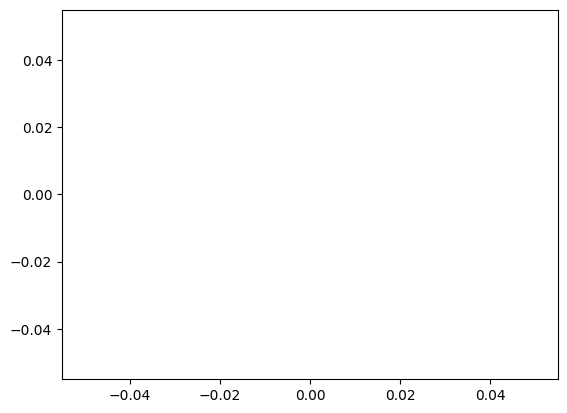

In [39]:
plt.plot(train_losses, label='Training Loss')
plt.show()


In [40]:
region_model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02-twitter", num_labels=4)
region_model = region_model.to(device)

region_model.train()


optimizer = torch.optim.AdamW(region_model.parameters(), lr=1e-5)

data_loader = DataLoader(train_data, batch_size=8, shuffle=True)

scaler = torch.cuda.amp.GradScaler(enabled=True)

train_losses = []
for epoch in range(3):
    total_loss = 0
    for index, batch in enumerate(tqdm(data_loader)):
        with torch.cuda.amp.autocast(enabled=True):
            inputs = batch
            max_len = 0
            for row in batch['input_ids']:
                vect = row[0]
                if tokenizer.pad_token_id in vect:
                    max_len = max(max_len, (vect == tokenizer.pad_token_id).nonzero()[0][0].item())
            if max_len == 0:
                max_len = 512
            inputs['input_ids'] = inputs['input_ids'][:, :, :max_len]
            inputs['attention_mask'] = inputs['attention_mask'][:, :, :max_len]
            inputs['input_ids'] = inputs['input_ids'].squeeze(1)
            inputs['attention_mask'] = inputs['attention_mask'].squeeze(1)
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['attention_mask'] = inputs['attention_mask'].to(device)

            inputs['labels'] = inputs['region_labels'].to(device)
            inputs.pop('dialect')  
            inputs.pop('region_labels')
            inputs.pop('region')
            
            outputs = region_model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        if quick and index == 4096:
            break
    # print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_data)}')
    train_losses.append(total_loss/len(train_data))



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  9%|▉         | 4096/45820 [09:14<1:34:10,  7.38it/s]


In [49]:
region_model.eval()

y_pred = []
y=[]

test_data = test_data.sample(frac=1).reset_index(drop=True)

for row in tqdm(test_data[:2048]):
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
        inputs = row
        inputs['input_ids'] = inputs['input_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        if 'labels' in inputs:
            labels = inputs.pop('labels')
        if 'dialect' in inputs:
            dialect = inputs.pop('dialect')
        if 'region_labels' in inputs:
            inputs.pop('region_labels')
        if 'region' in inputs:
            region = inputs.pop('region')

        y.append(region)
        outputs = region_model(**inputs)
        out_index = torch.argmax(outputs.logits, dim=-1)
        y_pred.append(region_list[out_index.item()])

  0%|          | 0/2048 [00:00<?, ?it/s]

100%|██████████| 2048/2048 [00:50<00:00, 40.38it/s]


In [52]:
for i in range(len(y)):
    print(f"True: {y[i]}, Predicted: {y_pred[i]}")

True: LEVANT, Predicted: LEVANT
True: GULF, Predicted: GULF
True: NILE BASIN, Predicted: NILE BASIN
True: GULF, Predicted: GULF
True: MAGHREB, Predicted: GULF
True: GULF, Predicted: GULF
True: GULF, Predicted: GULF
True: NILE BASIN, Predicted: NILE BASIN
True: LEVANT, Predicted: LEVANT
True: LEVANT, Predicted: GULF
True: MAGHREB, Predicted: MAGHREB
True: GULF, Predicted: GULF
True: GULF, Predicted: GULF
True: LEVANT, Predicted: LEVANT
True: NILE BASIN, Predicted: NILE BASIN
True: LEVANT, Predicted: LEVANT
True: GULF, Predicted: GULF
True: NILE BASIN, Predicted: NILE BASIN
True: MAGHREB, Predicted: MAGHREB
True: GULF, Predicted: LEVANT
True: GULF, Predicted: NILE BASIN
True: MAGHREB, Predicted: MAGHREB
True: LEVANT, Predicted: LEVANT
True: MAGHREB, Predicted: MAGHREB
True: GULF, Predicted: GULF
True: GULF, Predicted: GULF
True: MAGHREB, Predicted: MAGHREB
True: MAGHREB, Predicted: MAGHREB
True: MAGHREB, Predicted: MAGHREB
True: GULF, Predicted: GULF
True: NILE BASIN, Predicted: LEVANT
T

In [53]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')
print(f'Overall Region Accuracy: {accuracy} | F1: {f1}')


for region in region_list:
    correct = 0
    total = 0
    for i in range(len(y)):
        if y[i] == region:
            if(y[i] == y_pred[i]):
                correct +=1
            total +=1
    if total == 0:
        total = 1
    print(f'\tRegion: {region} | Accuracy: {correct/total}')

Overall Region Accuracy: 0.794921875 | F1: 0.794400061155825
	Region: GULF | Accuracy: 0.8508014796547472
	Region: LEVANT | Accuracy: 0.7758318739054291
	Region: MAGHREB | Accuracy: 0.7155963302752294
	Region: NILE BASIN | Accuracy: 0.7699115044247787


: 